# Getting started with NLP: Traditional approaches
# Word Embeddings, GloVe and Text classification

In this notebook we are going to explain the concepts and use of word embeddings in NLP, using Glove as en example. Then we will try to apply the pre-trained Glove word embeddings to solve a text classification problem using this technique.

We will use the Reuters dataset from NLTK as a demo of text classification. And as in others notebook we will follow the notebook from the great course on NLP by LazyProgrammer "Natural Language Processing in Python" and his notebook:

https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class2/bow_classifier.py

Link to blog post or aditional readings:
https://machinelearningmastery.com/what-are-word-embeddings/

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

## About the data
## Large Movie Review Dataset

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

Link to dataset:
http://ai.stanford.edu/~amaas/data/sentiment/

Publications Using the Dataset:

*Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)*.




## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

We set the variables for data location.

In [2]:
# Global parameters
#root folder
root_folder='.'
data_folder_name='data'
glove_filename='glove.6B.100d.txt'

train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'


## Word embeddings

**What is word embedding?**
Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning. The distributed representation is learned based on the usage of words. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. 

**How can we obtain the word embedings?**
1. **Embedding Layer**

An embedding layer is a word embedding that is learned in a neural network model on a specific natural language processing task. The documents or corpus of the task are cleaned and prepared and the size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. The vectors are initialized with small random numbers. The embedding layer is used on the front end of a neural network and is fit in a supervised way using the Backpropagation algorithm. 

It is a flexible layer that can be used in a variety of ways, such as:

- It can be used alone to learn a word embedding that can be saved and used in another model later.
- It can be used as part of a deep learning model where the embedding is learned along with the model itself.
- It can be used to load a pre-trained word embedding model, a type of transfer learning.

This approach requires a lot of training data and can be very slow, but will learn an embedding both targeted to the specific text data and the NLP task we are interested.

2. **Word2Vec**

Word2Vec is a statistical method for efficiently learning a standalone word embedding from a text corpus. It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more efficient and since then has become the de facto standard for developing pre-trained word embedding.

It learns the word embedding in one of two ways, either using context to predict a target word (a method known as continuous bag of words, or CBOW), or using a word to predict a target context, which is called skip-gram, for example, we’d like to predict c context words having one target word on the input. The latter method usually produces more accurate results on large datasets.

![CBOW model](images/CBOW.png "CBOW Model")

A well trained set of word vectors will place similar words close to each other in that space. The words oak, elm and birch might cluster in one corner, while war, conflict and strife huddle together in another.

3. **Glove**

The Global Vectors for Word Representation, or GloVe, algorithm is an extension to the word2vec method for efficiently learning word vectors, developed by Pennington, et al. at Stanford. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

GloVe is an approach to marry both the global statistics of matrix factorization techniques like LSA (Latent Semantic Analysis) with the local context-based learning in word2vec. Rather than using a window to define local context, GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus.

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. 
https://nlp.stanford.edu/pubs/glove.pdf

4. **Fasttext** 

The FastText model takes into account internal structure of words by splitting them into a bag of character n-grams and adding to them a whole word as a final feature. If we denote n-gram vector as z and v as output vector representation of word w (context word):

$$s(w,c)=\sum_{g\in G_w}z^T_gv_c$$

We can choose n-grams of any size, but in practice size from 3 to 6 is the most suitable one


#### Links
https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526


## Loading a pre-trained word embedding: GloVe

Files with the pre-trained vectors Glove can be found in many sites like Kaggle or in the previous link of the Stanford University. We will use the glove.6B.100d.txt file containing the glove vectors trained on the Wikipedia and GigaWord dataset.

First we convert the GloVe file containing the word embeddings to the word2vec format for convenience of use. We can do it using the gensim library, a function called glove2word2vec.

In [3]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_filename, word2vec_output_file)

(400000, 100)

So our vocabulary contains 400K words represented by a feature vector of shape 100. Now we can load the Glove embeddings in word2vec format and then analyze some analogies. In this way if we want to use a pre-trained word2vec embeddings we can simply change the filename and reuse all the code below.

In [4]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)

[('queen', 0.7698541283607483)]


## Analyzing the vector space and find analogies

We would like extract some interesting features of our word embeddings, we can measure and compare distances between word to show some of the properties that these embedding provide. 
For example, we can compare some analogies. The most famous is the following: king – man + woman = queen. In other words, adding the vectors associated with the words king and woman while subtracting man is equal to the vector associated with queen. Another example is: france – paris + rome = italy. In this case, the vector difference between paris and france captures the concept of country.

Now we will show some of thise analogies in different topics.


In [39]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('King - Man + Woman = ',result)
result = model.most_similar(positive=['rome', 'france'], negative=['paris'], topn=1)
print('France - Paris + Rome = ',result)
result = model.most_similar(positive=['english', 'france'], negative=['french'], topn=1)
print('France - french + english = ',result)
result = model.most_similar(positive=['june', 'december'], negative=['november'], topn=1)
print('December - November + June = ',result)
result = model.most_similar(positive=['sister', 'man'], negative=['woman'], topn=1)
print('Man - Woman + Sister = ',result)


AttributeError: 'RandomForestClassifier' object has no attribute 'most_similar'

We can observe how the word vectors include information to relate countries with nationalities, months of the year, family relationships, etc.

But not always we get the expected results:

In [20]:
#But not always we get the expected result
result = model.most_similar(positive=['aunt', 'nephew'], negative=['niece'], topn=1)
print('France - Paris + Rome = ',result)

France - Paris + Rome =  [('uncle', 0.8936851024627686)]


We can extract wich words are more similar to another word, so they all are "very close" in the vector space.

In [27]:
result = model.most_similar(positive=['spain'], topn=10)
print('10 most similar words to Spain: ',result)

result = model.most_similar(positive=['football'], topn=10)
print('\n10 most similar words to Football: ',result)

result = model.most_similar(positive=['doctor'], topn=10)
print('\n10 most similar words to Doctor: ',result)

10 most similar words to Spain:  [('portugal', 0.797070324420929), ('argentina', 0.7758234143257141), ('italy', 0.7746187448501587), ('france', 0.7557463645935059), ('spanish', 0.734722375869751), ('brazil', 0.724494457244873), ('mexico', 0.7206876277923584), ('madrid', 0.7078269124031067), ('morocco', 0.7001036405563354), ('netherlands', 0.6802704334259033)]

10 most similar words to Football:  [('soccer', 0.8732221126556396), ('basketball', 0.855563759803772), ('league', 0.8153362274169922), ('rugby', 0.8007533550262451), ('hockey', 0.7833694219589233), ('club', 0.7730998396873474), ('team', 0.7720499038696289), ('baseball', 0.7605736255645752), ('players', 0.7399718761444092), ('player', 0.7376238107681274)]

10 most similar words to Doctor:  [('physician', 0.7673239707946777), ('nurse', 0.75215083360672), ('dr.', 0.7175193428993225), ('doctors', 0.7080885171890259), ('patient', 0.7074184417724609), ('medical', 0.6995993256568909), ('surgeon', 0.6905338764190674), ('hospital', 0.690

In [24]:
#Lets show some measure of similarities between words
result = model.similar_by_word("cat")
print(" Cat is similar to {}: {:.4f}".format(*result[0]))
result = model.similar_by_word("father")
print(" Father is similar to {}: {:.4f}".format(*result[0]))

 Cat is similar to dog: 0.8798
 Father is similar to son: 0.9240


The idea behind all of the word embeddings is to capture with them as much of the semantical/morphological/context/hierarchical/etc. information as possible, but in practice one methods are definitely better than the other for a particular task (for instance, LSA is quite effective when working in low-dimensional space for the analysis of incoming documents from the same domain zone as the ones, which are already processed and put into the term-document matrix). The problem of choosing the best embeddings for a particular project is always the problem of try-and-fail approach, so realizing why in particular case one model works better than the other sufficiently helps in real work.



### Plotting some words in ther vector space

**Puede llevar mucho tiempo el calculo**

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


### Loading the dataset

Out IMdb reviews can be loaded from keras.dataset. But in this dataset the tokens has already been "numericalized", but we want them as plain text, so we need to reverse them to the original tokens. Then, we load the dataset, load the vocabulary and we will use the vocab to get the original token for every single token in the whole dataset.

In [28]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=None)

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

review = [reverse_word_index.get(i-3, "") for i in train_data[0]]

Using TensorFlow backend.


In [29]:
print('Vocabulary lenght: ',len(word_index))
print('Review example: ',review[:20])
print('Label: ',train_labels[0])

Vocabulary lenght:  88584
Review example:  ['', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you']
Label:  1


In [30]:
# Convert the train and test dataset to strings of words
X_train=[]
for doc in train_data:
    X_train.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))

X_test=[]
for doc in test_data:
    X_test.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))


In [32]:
print(len(X_train),len(X_test))
print(X_train[0])

25000 25000
 this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing an

## Applying the word embedding to a text classification task

Now, we have our word representation, a vector for every word in our vocabulary. But we need to deal with full sentences so we need to create a sentence embedding, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the word embeddings. There are many posibilities and we are notr going to cover this topic, so we apply a very simple method: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence. 


In [33]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

Next, we create a Vectorizer object that will help us to transform our reviews to vectors, a numerical representation. Then we can use those vectors to feed our classifier.

In [34]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = train_labels
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = test_labels


Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 25000
Numer of samples with no words found: 0 / 25000


In [35]:
print(Xtrain.shape,Xtest.shape)

(25000, 100) (25000, 100)


## Train a classifier on the sentence embeddings

As text classification is just a type of classification problem we can apply some of the well-known classifiers to predict the label of a text. The next cells build different models to solve our classification task.

**Simple explanation of classification text and mention the algo to use**

### A random forest classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

# create the model, train it, print scores
clf = RandomForestClassifier(n_estimators=200)

clf.fit(Xtrain, Ytrain)

print("train score:", clf.score(Xtrain, Ytrain))
print("test score:", clf.score(Xtest, Ytest))


train score: 1.0
test score: 0.76


### An Adaboost classifier

In [41]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=300, random_state=0)
clf.fit(Xtrain, Ytrain)

print("train score:", clf.score(Xtrain, Ytrain))
print("test score:", clf.score(Xtest, Ytest))


train score: 0.80912
test score: 0.7786


## Evaluating the model

In [46]:
# Predicting the Test set results
y_pred = clf.predict(Xtest)

# Building the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc
cm = confusion_matrix(Ytest, y_pred)
print('Confusion Matrix: ',cm)
# Calculate the accuracy
acc = accuracy_score(Ytest, y_pred)
print('Accuracy: ',acc)

fpr, tpr, thresholds = roc_curve(Ytest, y_pred, pos_label=1)
roc_auc= auc(fpr,tpr)

Confusion Matrix:  [[9296 3204]
 [2772 9728]]
Accuracy:  0.76096


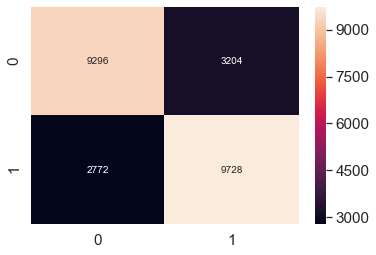

In [47]:
import seaborn as sn
# Create a dataframe with the confussion matrix values
df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
# Plot the confussion matrix
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size

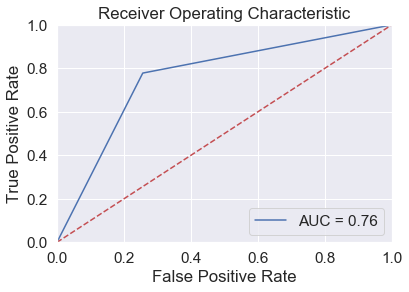

In [48]:
# ROC Curve
# plot no skill
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
